# Preparation of the bathymetry, topography, coast_line files needed to create the FEMTIC mesh

Example with the AusLAMP South Australia Dataset

In [1]:
import sys
sys.path.append('../../src')
import femticPy

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

## 1. Set up DataGen object
 
 First a femticpy.DataGen object has to be created to load the MT data and coordinates

In [3]:
# the file will be written in the input_data directory
auslamp_inv = femticPy.DataGen(survey = 'auslamp', outdir = './input_data')

In [4]:
# Loading the data and the data coordinates
auslamp_inv.read_MTdata('./input_data/edi_files/')
auslamp_inv.read_MTdata_coordinates('./input_data', 'coord_auslampSA')

    reading EP001.edi
    reading EP002.edi
    reading EP003.edi
    reading EP004.edi
    reading EP005.edi
    reading EP006.edi
    reading EP007.edi
    reading EP008.edi
    reading EP009.edi
    reading FR03.edi
    reading FR04.edi
    reading FR05.edi
    reading FR06.edi
    reading FR07.edi
    reading FR08.edi
    reading FR09.edi
    reading FR10.edi
    reading FR11.edi
    reading FR12.edi
    reading FR13.edi
    reading FR14.edi
    reading FR15.edi
    reading FR16.edi
    reading FR17.edi
    reading FR18.edi
    reading FR19.edi
    reading FR20.edi
    reading FR21.edi
    reading FR22.edi
    reading FR23.edi
    reading FR24.edi
    reading FR25.edi
    reading FR27.edi
    reading FR28.edi
    reading FR29.edi
    reading NF22.edi
    reading NF23.edi
    reading NF24.edi
    reading NF27.edi
    reading NF28.edi
    reading NF38.edi
    reading NF41.edi
    reading NF42.edi
    reading NF43.edi
    reading NF44.edi
    reading SA001.edi
    reading SA002.edi
  

In [5]:
# we center the data to a anchor point (center of the data set) which will also be the center of the future mesh
auslamp_inv.center_data()
auslamp_inv.anchor

[6190.4220000000005, 715.3695]

In [6]:
# we can check the coordinates in utm format (original) or respect to the future mesh
auslamp_inv.mt_coords_utm  # real world coordinates
auslamp_inv.mt_coords      # in mesh coordinates

,id,east,north,z
0,EP001,-125.0065,-60.690,-0.112880
1,EP002,-159.6985,-47.571,-0.048853
2,EP003,34.6885,-63.469,-0.028520
3,EP004,-24.3015,-67.285,-0.032904
4,EP005,54.4945,-154.690,-0.146430
...,...,...,...,...
104,SA203,6.4365,143.750,-0.075474
105,SA204,0.7905,219.054,-0.127897
106,SA400,-310.0345,216.566,-0.005000
107,SA401,-263.0525,212.944,-0.045561


In [7]:
# we define the analysis domain, the extent of the total mesh including padding
# the DEM used needs to cover beyond the analysis domain
auslamp_inv.analysis_domain = [[-1100.0, 1100.0],
                                [-1100.0, 1100.0],
                                [-1100.0, 1100.0]]   

 ## 2. Prepare the files

In [8]:
# DEM file downloaded from   https://www.ncei.noaa.gov/maps/grid-extract/  as   ETOPO2022 Bedrock 60 sec
# The bedrock .TIFF file contains elevations, which can be converted to .xyz file in QGIS (using gdal2xyz)
# 

In [9]:
dem_file = './input_data/dem.xyz'
dem_geo = pd.read_csv(dem_file,  names=['Longitude','Latitude','z'] )

In [10]:
# transform geographical coordinates into utm using pyproj
def deg2utm(df,zone,south=True):
    from pyproj import Proj
    p = Proj(proj='utm', ellps='WGS84', zone=zone, south=south)
    lat_UTM = []
    long_UTM = []
    for i in range(len(df)):
        lat,lon = p(df['Longitude'][i],df['Latitude'][i])
        long_UTM.append(lon)
        lat_UTM.append(lat)
    df['east'] = np.array(lat_UTM) / 1000
    df['north'] = np.array(long_UTM) /1000
    return df


In [11]:
UTM_zone = 53
dem = deg2utm(dem_geo, zone=UTM_zone, south=True)
dem.shape

(2567356, 5)

In [12]:
#The DEM is a bit large we resample it every 5 pts 
ptx = pd.unique(dem['east'])[::5]
pty = pd.unique(dem['north'])[::5]
ny = len(pty)
nx = len(ptx)

dem_sp = dem[dem['east'].isin(ptx)]
dem_sp = dem_sp[dem_sp['north'].isin(pty)]

dem_sp.reset_index(inplace=True)

dem = dem_sp
dem.shape

(513472, 6)

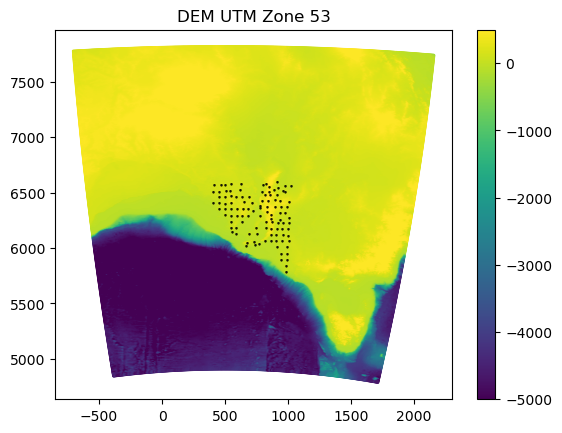

In [13]:
#plot the DEM along with the stations to check if all is in order
cb = plt.scatter(dem['east'], dem['north'], c=dem['z'], vmin = -5000, vmax = 500,s=1)
plt.plot(auslamp_inv.mt_coords_utm['east'], auslamp_inv.mt_coords_utm['north'], 'kv',ms=1)
plt.title('DEM UTM Zone %d'%UTM_zone)
plt.colorbar(cb)

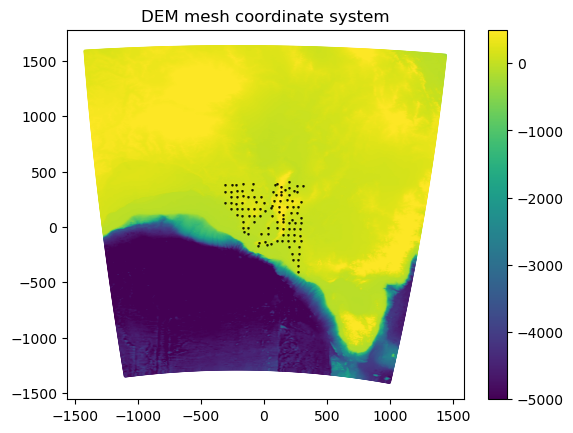

In [14]:
# Center the DEM to the mesh coordinates and plot to check if all is ok
dem['north'] -= auslamp_inv.anchor[0]
dem['east']  -= auslamp_inv.anchor[1]

cb = plt.scatter(dem['east'], dem['north'], c=dem['z'], vmin = -5000, vmax = 500,s=1)
plt.plot(auslamp_inv.mt_coords['east'], auslamp_inv.mt_coords['north'], 'kv',ms=1)
plt.title('DEM mesh coordinate system')
plt.colorbar(cb)

## 2.1 Create the coast line file

### 2.1.1 Extract coast from DEM file

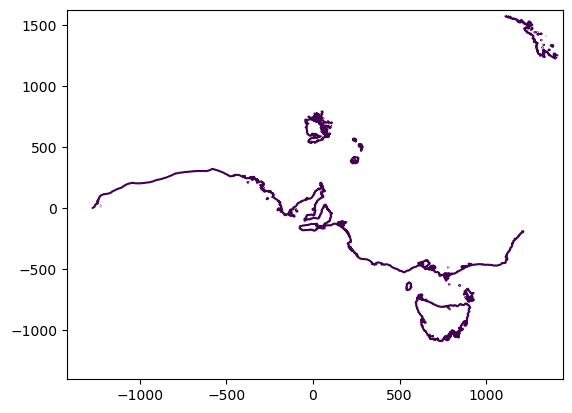

In [15]:
# using the tricontour function we can extract the 0m elevation contour, the coasts
CS = plt.tricontour(dem['east'][::1],dem['north'][::1],dem['z'][::1], [0])

In [16]:
# here we extract the polygons corresponding to the 0m elevation contour (lakes, island, coast)
polygons = CS.get_paths()[0].to_polygons() # extract polygons
len(polygons)

149

In [17]:
# We have many polygons (149), we want only the major polygons (longer ones: principal coast lines and islands)
polygons.sort(key=len) # sort by length

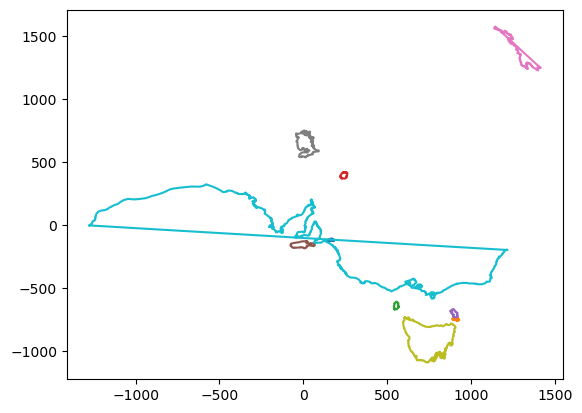

In [18]:
# we plot the last 10 polygons (the largests) , to see what to keep or not
for polygon in polygons[-10:]:
    plt.plot(polygon[:,0], polygon[:,1])

In [19]:
polygons = polygons[-5:][::-1] # only keep the last 5 polygons
polygons[0] = polygons[0][:-1]  # this line is optional to remove a duplicated point in the first polygon (the largest, the main coast)

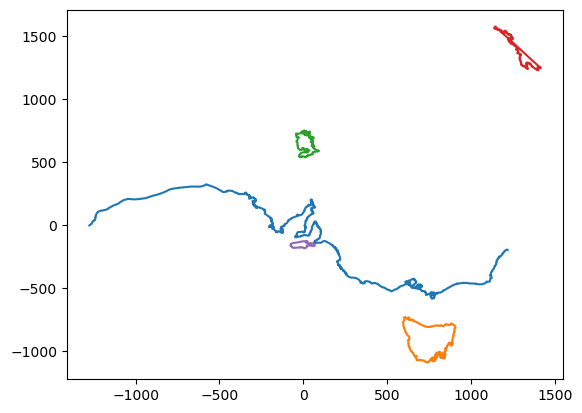

In [20]:
# we plot the 5 polygons that were extracted, to see what to keep or not
for polygon in polygons:
    plt.plot(polygon[:,0], polygon[:,1])

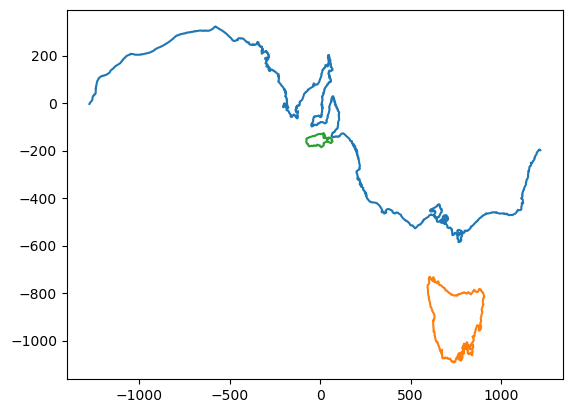

In [21]:
# we want to remove the lake up north (in green) and the coast north east
polygons = [polygons[i] for i in [0,1,4]] # we remove polygon 2 and 3
for polygon in polygons:
    plt.plot(polygon[:,0], polygon[:,1])

#plt.xlim(750, 850)
#plt.ylim(-1100, -1000)

### 2.1.2 Simplify coast line

Simplfying the coast line is recommended to avoid coast lines crossing which will cause the mesh generator to fail

In [22]:
#using the Ramer-Douglas-Peucker algorithm
from rdp import rdp

(-200.0, 200.0)

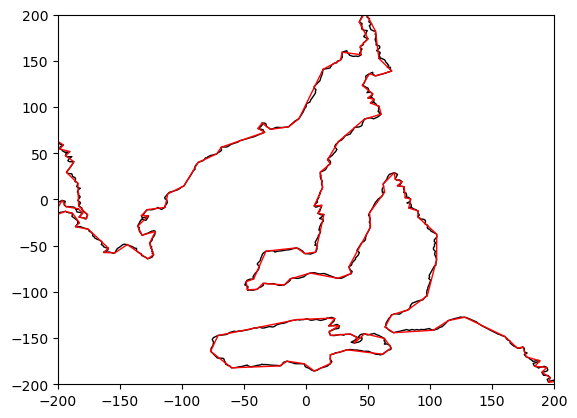

In [23]:
polygons_simplfied = []
for i in range(len(polygons)):
        cl = polygons[i]
        mask = rdp(cl, algo="iter", return_mask=True, epsilon=3) # chech rdp repo for details, epsilon controls the simplification
        plt.plot(cl[:,0],cl[:,1], 'k-',lw=1)
        clm = cl[mask]
        plt.plot(clm[:,0],clm[:,1], 'r-',lw=1)
        polygons_simplfied.append(clm)

plt.xlim(-200,200)
plt.ylim(-200,200)

In [24]:
def write_coast_file(polygons, outdir, plot = False):
    
    file_loc = os.path.join(outdir, 'coast_line.dat') 
    file = open(file_loc,'w') 
    file.write('%d\n'%len(polygons))
    for i in range(len(polygons)):
        cl0 = polygons[i][::-1]
        if plot:
            plt.plot(cl0[:,0],cl0[:,1], 'k-')
            
        for j in range(len(polygons[i])):
            if j == (len(polygons[i])-1):
                file.write(' %4.1f %4.1f 1 0\n'%(cl0[j,1], cl0[j,0]))
            else:
                file.write(' %4.1f %4.1f 0 0\n'%(cl0[j,1], cl0[j,0]))
    file.close() 

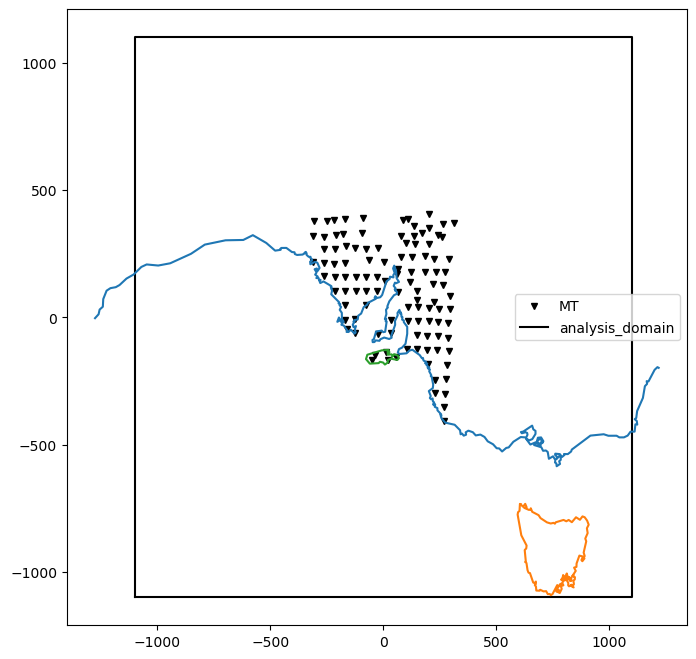

In [25]:
# before writing the file we want to check the coast line contour respect to the mesh
auslamp_inv.plot_data_loc(plot_ids = False)
for polygon in polygons_simplfied:
    plt.plot(polygon[:,0], polygon[:,1])

In [26]:
#It fits, the coast line goes beyond the mesh domain, we just need to close the main coast polygon
main_coast = polygons_simplfied[0]
main_coast = np.r_[np.array([[main_coast[-1,0],1500]]), np.array([[main_coast[0,0],1500]]), main_coast]
polygons_simplfied[0] = main_coast

(-1400.2590077347293, 1342.3549105320662, -1230.0, 1630.0)

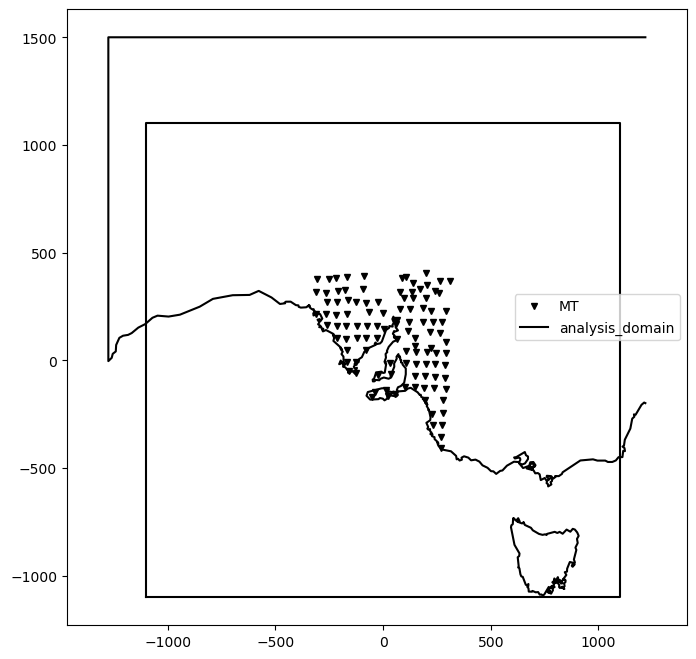

In [27]:
# write the file and plot the MT data
auslamp_inv.plot_data_loc(plot_ids = False)
write_coast_file(polygons_simplfied, outdir='./input_data', plot = True)
plt.axis('equal') 
#plt.xlim(-200,-100)
#plt.ylim(-200,-100)

## 2.2 Create topo and bathy files
* Both files contains coordinates of the complete DEM
* The bathy file has positive values for negative elevations, and positive elevations are set to -1m
* The topo file has positive values for positive elevations, and negative elevations are set to -1m
* Check FEMTIC docs for details

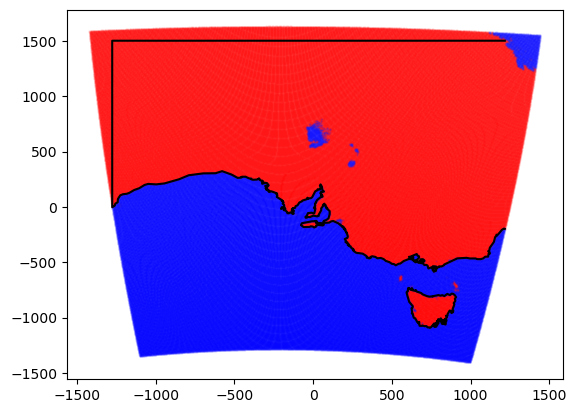

In [28]:
plt.scatter(dem['east'][dem['z']>0], dem['north'][dem['z']>0],c='r',s=0.5, alpha=0.1)
plt.scatter(dem['east'][dem['z']<0], dem['north'][dem['z']<0],c='b',s=0.5, alpha=0.1)

for polygon in polygons_simplfied:
    plt.plot(polygon[:,0], polygon[:,1], 'k')

Here we want to clean lakes and islands because the 0 elevation contour line doesn't consider them. Lakes to be set at a minimum elevation of +1m and islands at a maximum elevation of -1m

In [29]:
# Using shapely, a bit slow for now...
from shapely.geometry import Point, Polygon

In [30]:
# we extract the dem from the dataframe to work with it
dem_z = np.array(dem['z'])
dem_z

array([  143.402,   144.511,   177.461, ..., -4686.68 , -4688.69 ,
       -4697.94 ])

In [31]:
visited = np.full(len(dem_z), False)

# for each polygons loop over the coordinates points and determine whether it is inside the polygon (inLand) 
# and if it contains a negative elevation, to put it above sea level. Outside the polygons, 
# if contains a positive elevation, to put it below sea level

for p in range(len(polygons)):

    polygon_data = polygons[p]

    if p == 0: # first polygon is not closed, let's close it
        polygon_data = np.r_[np.array([[-1800,1800]]), np.array([[-1800,polygon_data[0,1]]]),polygon_data, np.array([[1800,polygon_data[-1,1]]]), np.array([[1800,1800]]), np.array([[-1800,1800]])]
    
    poly = Polygon(polygon_data)

    for i in range(len(dem)):
        if i %10000==0: print('%d/%d'%(i,len(dem)))
                        
        if poly.contains(Point(dem['east'][i], dem['north'][i])):
            inLand = True
            visited[i] = True
        else: inLand = False
            
        if inLand and dem_z[i] < 0:
            dem_z[i] = 1
            
        if inLand==False and dem_z[i] > 0 and visited[i]==False:
            dem_z[i] = -1


0/513472
10000/513472
20000/513472
30000/513472
40000/513472
50000/513472
60000/513472
70000/513472
80000/513472
90000/513472
100000/513472
110000/513472
120000/513472
130000/513472
140000/513472
150000/513472
160000/513472
170000/513472
180000/513472
190000/513472
200000/513472
210000/513472
220000/513472
230000/513472
240000/513472
250000/513472
260000/513472
270000/513472
280000/513472
290000/513472
300000/513472
310000/513472
320000/513472
330000/513472
340000/513472
350000/513472
360000/513472
370000/513472
380000/513472
390000/513472
400000/513472
410000/513472
420000/513472
430000/513472
440000/513472
450000/513472
460000/513472
470000/513472
480000/513472
490000/513472
500000/513472
510000/513472
0/513472
10000/513472
20000/513472
30000/513472
40000/513472
50000/513472
60000/513472
70000/513472
80000/513472
90000/513472
100000/513472
110000/513472
120000/513472
130000/513472
140000/513472
150000/513472
160000/513472
170000/513472
180000/513472
190000/513472
200000/513472
210000

In [32]:
bathy_data = -np.where(dem_z > 0, 1, dem_z)
topo_data = np.where(dem_z < 0, -1, dem_z)

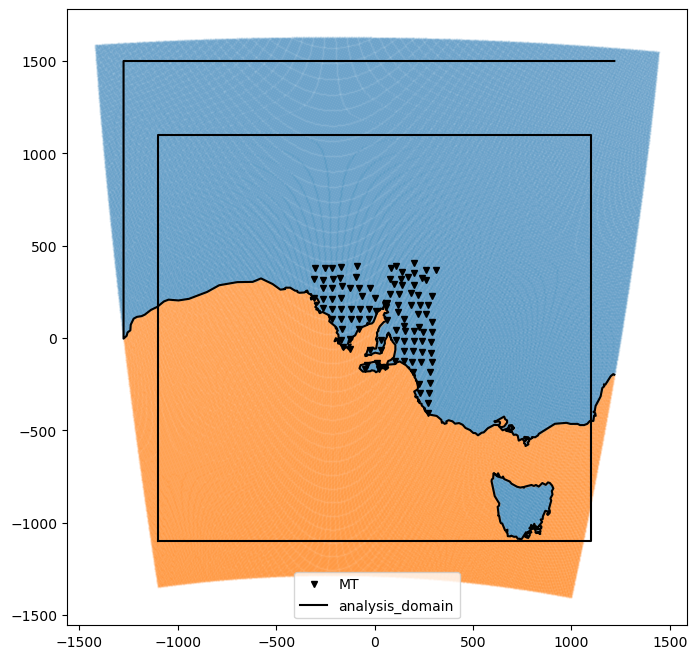

In [33]:
# we plot MT data and inversion domain, topo/bathy and the coast line
auslamp_inv.plot_data_loc(plot_ids = False)
plt.scatter(dem['east'][topo_data>0], dem['north'][topo_data>0],s=0.5, alpha=0.1)
plt.scatter(dem['east'][bathy_data>0], dem['north'][bathy_data>0],s=0.5, alpha=0.1)
for polygon in polygons_simplfied:
    plt.plot(polygon[:,0], polygon[:,1], 'k')
#plt.xlim(-500,500)
#plt.ylim(-500,500)

In [34]:
#The files are written in km

def write_topo_file(dem, topo_data, outdir):
        file_loc = os.path.join(outdir, 'topography.dat') 
        file = open(file_loc,'w') 
        for i in range(len(dem)):
            file.write('%4.3f %4.3f %4.3f\n'%(dem['north'][i], dem['east'][i], topo_data[i]/1000))
        file.close() 

def write_bathy_file(dem, bathy_data, outdir):
        file_loc = os.path.join(outdir, 'bathymetry.dat') 
        file = open(file_loc,'w') 
        for i in range(len(dem)):
            file.write('%4.3f %4.3f %4.3f\n'%(dem['north'][i], dem['east'][i], bathy_data[i]/1000))
        file.close() 


In [35]:
write_topo_file(dem,  topo_data,  outdir='./input_data')
write_bathy_file(dem, bathy_data, outdir='./input_data')

## 2.3  Modify elevation of the MT sites to match the topography

In order to have the ellipses closely centered on the earth surface. If there are (larges) differences between the MT data elevation and the DEM the ellipses will be hanging in the air (or water) a bit or b benaeth the surface, which will cause the smaller cells close to the site to not be centered, and some high resolution might be lost.

We use a kdtree to align elevation of mt site with topo (closest elevation will be assigned)

In [36]:
from scipy.spatial import KDTree
tree = KDTree(np.c_[dem['east'],dem['north']])
dd, ii = tree.query(np.c_[auslamp_inv.mt_coords['east'].values, auslamp_inv.mt_coords['north'].values], k=1)
mt_elev = dem['z'][ii].values

In [37]:
# to avoid to have MT site underground, just in case
mt_elev = np.where(mt_elev < 5, 5, mt_elev)

In [38]:
# rewrite mt_coords:
auslamp_inv.mt_coords_utm['z'] =  mt_elev / 1000
outdir_coords = './input_data/coord_auslampSA'

# WARNING: this will overwrite the original coordinate file 
auslamp_inv.mt_coords_utm.to_csv(outdir_coords,index=False,header=False, sep= '\t')